In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/Task1_2inputs")
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
from MyDenseNet import MyDenseNet121
!pip install medcam
import cv2
from medcam import medcam
from skimage.transform import rescale, resize
import nibabel as nib
import torch
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.6 MB/s eta 0:00:00
  Created wheel for medcam: filename=medcam-0.1.21-py3-none-any.whl size=23193 sha256=7d596f4fd16c8a567aa2d2780ceee652739963180c161bf220aac59024a8a3c3
  Stored in directory: /root/.cache/pip/wheels/fb/5a/1c/f04ac691163a19657feccb3904d12d68e6391a5a859749d8d5
Successfully built medcam


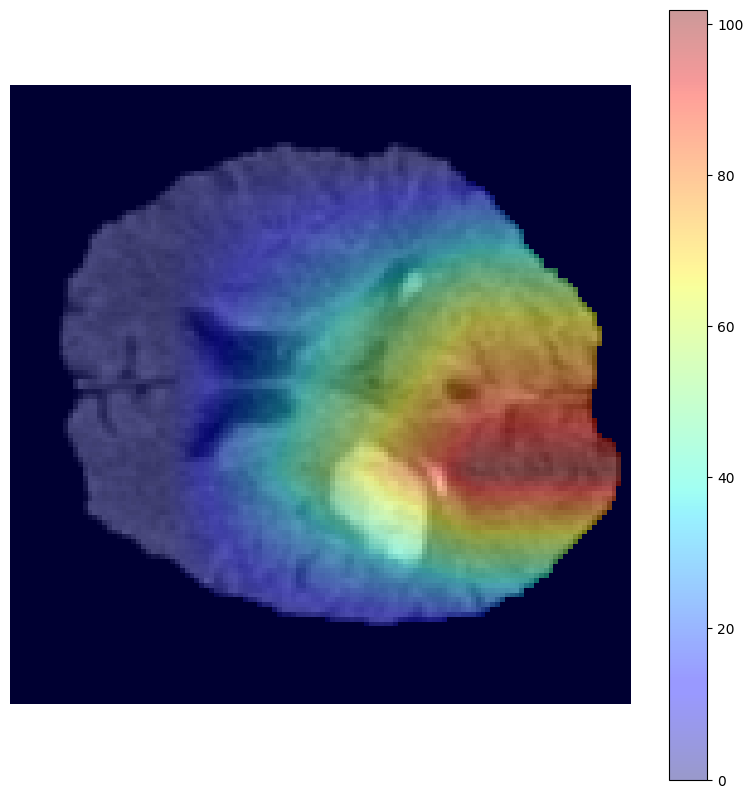

In [14]:
import numpy as np

path = "data/scale192to128_96_dilation/validation/19956_brain_seg.nii.gz"
nii = nib.load(path)
img = nii.get_fdata()
img = torch.unsqueeze(torch.from_numpy(img), 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyDenseNet121(
    spatial_dims=3, in_channels=2, out_channels=128, dropout_prob=0.2).to(device)
model.load_state_dict(torch.load(
    "96dilation_best_metric_model_classification3d_11.pth", map_location=torch.device('cpu')))
model.eval()
model2 = medcam.inject(model, output_dir='attention_maps', backend='gcam', layer='class_layers.relu', label='best',
                       save_maps=True)
model2(img.float())
nii_map = nib.load("attention_maps/class_layers.relu/attention_map_0_0_0.nii.gz")
img_map = nii_map.get_fdata()
outputCT = img[0, 0, :, :, 12:76].cpu().numpy()
outputMap = np.transpose(img_map, [2, 1, 0])
outputMap = cv2.resize(outputMap[:, :, 0], (128, 128))
outputMap[outputCT[:, :, 24] == 0] = 0
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
output = outputMap * 0.4 + outputCT[:, :, 24]
ax = axes
im_show = ax.imshow(outputCT[:, :, 24], cmap="gray")
ax.axis('off')
im_show = ax.imshow(output, alpha=0.4, cmap="jet")
ax.axis('off')
fig.colorbar(im_show, ax=ax)
plt.savefig("example.png")
